In [1]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import os
import shutil

import representation
import kex_data
import kex_headers
import listmode
import petlink
import position
import e7tools
import filefit as ff

In [2]:
hdrs = kex_data.get_sino_hdrs()
mhdrs = kex_data.get_sino_mainhdrs()
for h,m in zip(hdrs, mhdrs):
    filling = [h,m]
    mc_dir = r"C:/Users/petct/Desktop/Hugo/Code/PythonMEX/motion_corrected"
    ff.prep_folder(mc_dir, filling)

In [3]:
limo, _ = kex_data.listmode()

In [4]:
limo = [v[:1000*1000] for v in limo]#subset for testing

In [5]:
limo_recon = [listmode.get_fov_image_bins(v) for v in limo]

In [20]:
limo_com = [position.listmode_center(v['fov_image_bins']) for v in limo_recon]
limo_com = dict(zip(kex_data.DATA_KEYS, limo_com))

In [21]:
toflor = [v['tof_lor'] for v in limo_recon]
is_prompt = [v['is_prompt'] for v in limo_recon]
norms = kex_data.get_my_norms()
weights = [listmode.get_norms(*x) for x in zip(toflor, is_prompt, norms)]

In [22]:
#move gate 1 to gate 0
ref = np.zeros(3)
prompts = [t[:, p] for t,p in zip(toflor, is_prompt)]
toflor_mix = {}
norm_mix = {}
for (dkey, com), t, w, is_p in zip(limo_com.items(), toflor, weights, is_prompt):
    pkey = dkey.split(" ")[0]
    if dkey.endswith('0'):
        ref = com
        toflor_mix[pkey] = t[:,is_p]
        norm_mix[pkey] = w*0+1 #normalized by e7recon
    else:
        translation = ref - com #move to reference, pos + (ref - pos) = ref + 0
        translation_mm = translation*kex_headers.MM_PER_PIXEL
        moved_toflor, is_fov = representation.move_translation(t[:, is_p], translation_mm)
        toflor_mix[pkey] = listmode.join_gates((toflor_mix[pkey], moved_toflor[:, is_fov]))
        norm_mix[pkey] = listmode.join_gates((norm_mix[pkey], w[is_fov]))

In [10]:
#convert into sinogram
shape = kex_headers.HISTOGRAM_SHAPE
mc_sinograms = {k: listmode.get_histogram(v, shape) for k,v in limo_mix.items()}

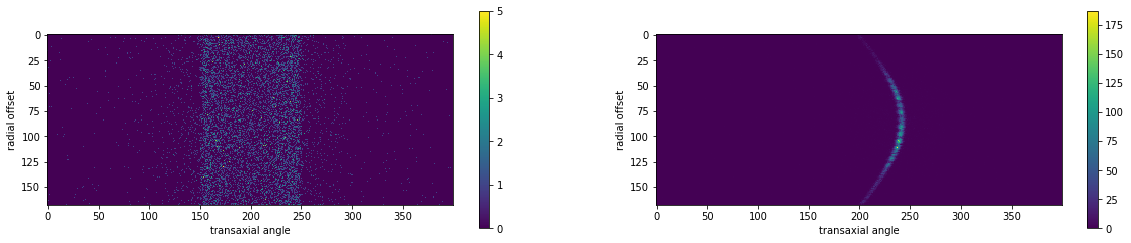

In [11]:
#check before saving and reconstructing
fig, axes = plt.subplots(ncols=2, figsize=(20,4))
axes = dict(zip(kex_data.PHANTOM_KEYS, axes))
for pkey, ax in axes.items():
    tof= 0
    mi = 50
    im = ax.imshow(mc_sinograms[pkey][tof, mi])
    ax.set_xlabel("transaxial angle")
    ax.set_ylabel("radial offset")
    fig.colorbar(im, ax=ax)

In [21]:
#save to ref
ref = 0
sino_paths = kex_data.get_sino_paths()
sino_paths = ff.refolder_paths(mc_dir, sino_paths)
sino_paths = dict(zip(kex_data.DATA_KEYS, sino_paths))
for pkey in kex_data.PHANTOM_KEYS:
    dkey = pkey + " " + kex_data.GATE_KEYS[ref]
    output_path = sino_paths[dkey]
    print(output_path)
    with open(output_path, 'wb') as file:
        sino = mc_sinograms[pkey].astype('uint16')
        file.write(sino)

C:/Users/petct/Desktop/Hugo/Code/PythonMEX/motion_corrected/CylinderPET-LM-00-sino-0.s
C:/Users/petct/Desktop/Hugo/Code/PythonMEX/motion_corrected/KanylPET-LM-00-sino-0.s


In [24]:
#reconstruct with e7tools
mc_mhdrs = ff.refolder_paths(mc_dir, kex_data.get_sino_mainhdrs())
mc_mhdrs = dict(zip(kex_data.DATA_KEYS, mc_mhdrs))
for pkey in kex_data.PHANTOM_KEYS:
    dkey = pkey + " " + kex_data.GATE_KEYS[ref]
    image_path = mc_dir + "/"+pkey
    npath = kex_data.NORM_PATH
    print("return code", 
          e7tools.kex_recon(mc_mhdrs[dkey], npath, image_path, verbose=True))

stdout
 b''
stderr
 b"I 05/29/2020 15:47:41.571 (UTC+01:00) Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz (1x)    memory: 32629 MByte
I 05/29/2020 15:47:41.571 (UTC+01:00) Number of NUMA nodes: 1
I 05/29/2020 15:47:41.571 (UTC+01:00) Number of physical processor packages: 1
I 05/29/2020 15:47:41.571 (UTC+01:00) Number of processor cores: 4
I 05/29/2020 15:47:41.571 (UTC+01:00) Number of logical processors: 8
I 05/29/2020 15:47:41.571 (UTC+01:00) Number of processor L1/L2/L3 caches: 8/4/1 
I 05/29/2020 15:47:41.571 (UTC+01:00) Hyper-Threadingin BIOS Enabled.
I 05/29/2020 15:47:41.571 (UTC+01:00)  supported CPU features: MMX,SSE,SSE2,SSE3,SSE4.1,SSE4.2,AVX
I 05/29/2020 15:47:41.777 (UTC+01:00) GPU Driver Version: 24.20.100.6286
I 05/29/2020 15:47:41.778 (UTC+01:00) GPU Driver supported CUDA Version: 9010
I 05/29/2020 15:47:41.778 (UTC+01:00) CUDA Run-time Version Used: 5000
I 05/29/2020 15:47:41.778 (UTC+01:00) Quadro M620 1017 MHz (Compute Capability 5.0)
I 05/29/2020 15:47:41.778 (UTC+01:0

stdout
 b''
stderr
 b"I 05/29/2020 15:48:15.001 (UTC+01:00) Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz (1x)    memory: 32629 MByte
I 05/29/2020 15:48:15.001 (UTC+01:00) Number of NUMA nodes: 1
I 05/29/2020 15:48:15.001 (UTC+01:00) Number of physical processor packages: 1
I 05/29/2020 15:48:15.001 (UTC+01:00) Number of processor cores: 4
I 05/29/2020 15:48:15.001 (UTC+01:00) Number of logical processors: 8
I 05/29/2020 15:48:15.001 (UTC+01:00) Number of processor L1/L2/L3 caches: 8/4/1 
I 05/29/2020 15:48:15.001 (UTC+01:00) Hyper-Threadingin BIOS Enabled.
I 05/29/2020 15:48:15.001 (UTC+01:00)  supported CPU features: MMX,SSE,SSE2,SSE3,SSE4.1,SSE4.2,AVX
I 05/29/2020 15:48:15.170 (UTC+01:00) GPU Driver Version: 24.20.100.6286
I 05/29/2020 15:48:15.171 (UTC+01:00) GPU Driver supported CUDA Version: 9010
I 05/29/2020 15:48:15.171 (UTC+01:00) CUDA Run-time Version Used: 5000
I 05/29/2020 15:48:15.171 (UTC+01:00) Quadro M620 1017 MHz (Compute Capability 5.0)
I 05/29/2020 15:48:15.171 (UTC+01:0

In [25]:
def get_v_data(path, shape=(109,200,200),dtype=np.float32):
    count = np.prod(shape)
    with open(path, 'rb') as file:
        img = np.fromfile(file, dtype=dtype, count=count)
    return np.reshape(img, newshape=shape)

In [71]:
#get reconstructions
vfiles = []
with os.scandir(mc_dir) as it:
    for entry in it:
        if entry.is_file() and entry.name.endswith('.v'):
            print("v file", entry.name)
            vfiles.append(entry.name)
vfiles = dict(zip(kex_data.PHANTOM_KEYS, vfiles[::-1]))
mc_recon = {k: get_v_data(mc_dir+"/"+v) for k,v in vfiles.items()}

v file cannula_000_000.v
v file cylinder_000_000.v


In [72]:
import volume_view as vv
import visual
def my_plot(img_dict, pos = [47,120,100]):
    nims = len(img_dict)
    fig, axes = plt.subplots(nrows=nims, ncols=3, figsize=(20, 7*nims))
    for (key,img), row in zip(img_dict.items(), axes):
        dimlabels = 'zyx'
        views = vv.plot_views(img, 
                      position=pos,
                      axes=row, 
                      dimlabels=dimlabels, 
                      img_title=key)
        visual.same_colorbar(fig, views, row)

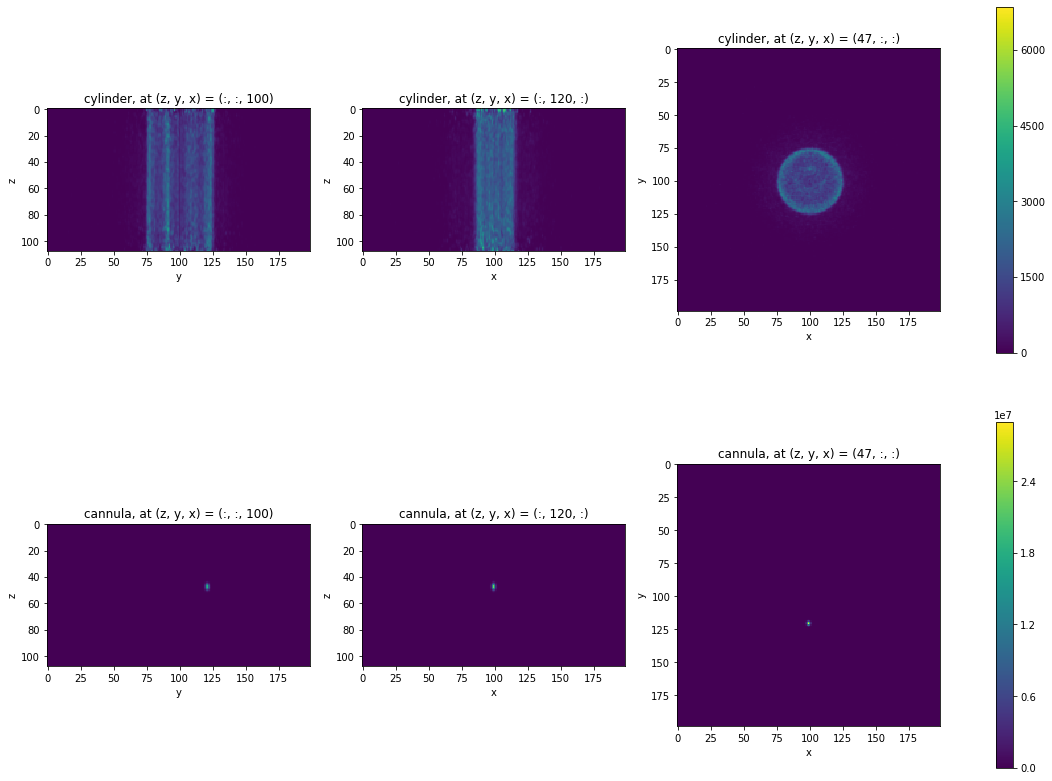

In [73]:
my_plot(mc_recon)

In [74]:
importlib.reload(kex_data)
ref_v_recon = kex_data.get_v_data()
_,_, dicom_paths = kex_data.paths()
print(dicom_paths)
print(ref_v_recon.keys())

['C:/Users/petct/Desktop/KanylPET-Converted/KanylPET-LM-00/KanylPET-LM-00-OPTOF_000_000.v-DICOM', 'C:/Users/petct/Desktop/KanylPET-Converted/KanylPET-LM-01/KanylPET-LM-01-OPTOF_000_000.v-DICOM']
dict_keys(['cylinder 0', 'cylinder 1', 'cannula 0', 'cannula 1'])


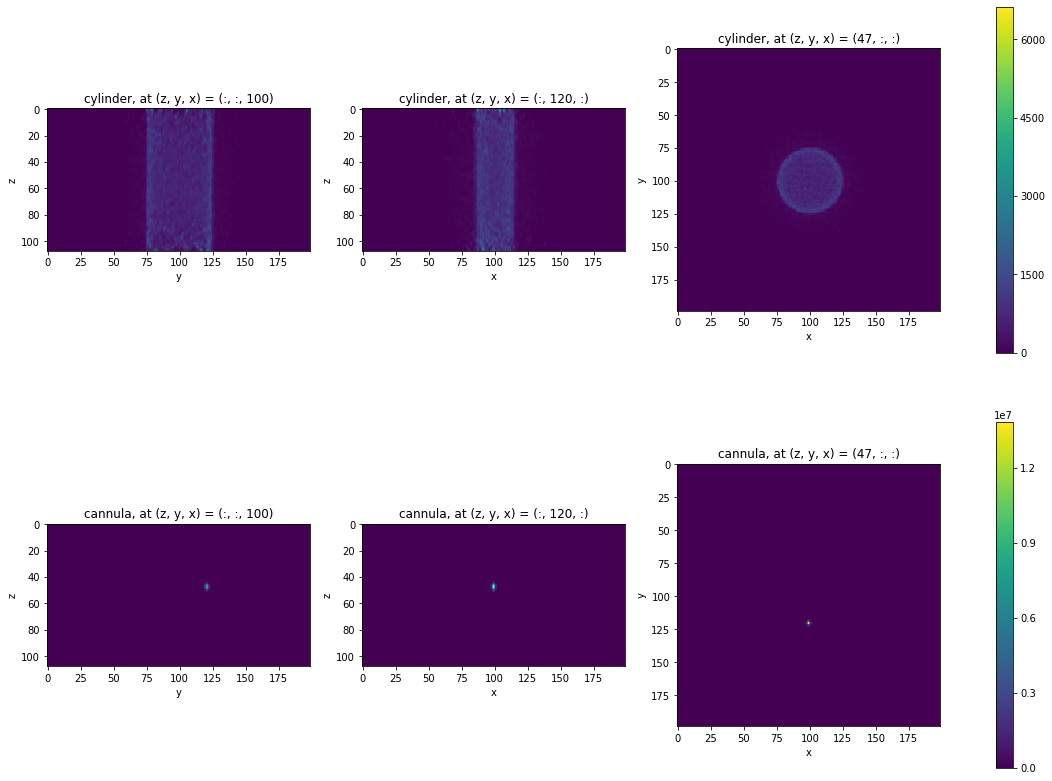

In [75]:
my_plot({pkey: ref_v_recon[pkey+" 0"] for pkey in kex_data.PHANTOM_KEYS})